# LSTM2

In [11]:
# 모듈로딩
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## [ 학습 함수 ]
---

In [12]:
# [ 학습 함수 ]
# ex: data = [1,2,3,4,5,6,7,8,9,10]가 주어졌을 때 generateX(data, 5)를 실행하면
# 아래와 같은 학습데이터 변환한다.
#
# x                      y
# ---------              -
# 1,2,3,4,5              6
# 2,3,4,5,6              7
# 3,4,5,6,7              8
# ...

# a= data, n = 학습할 과거 데이터 수
# --> 예측값 개수 : 전체 데이터 갯수 - n (앞쪽데이터 n개가 제외됨)

def generateX(a, n): # a=data, n=5
    x_train = []
    y_train = []
    for i in range(len(a)): # i = 0~9 
        x = a[i:(i + n)] # x : 0~4,1~5,2~6,3~7,4~8,5~9...9~14
        if (i + n) < len(a): # target data가 있는 범위까지만
            x_train.append(x) # x_train = 0~4,1~5,2~6,3~7,4~8까지
            y_train.append(a[i + n]) # y_train = 5,6,7,8,9
        else:
            break
    return np.array(x_train), np.array(y_train)
    # x_train 개수: date개수 - n(뒤)
    # y_train 개수: date개수 - n(앞)

### 테스트 방법
---
1. data : 데이터 총 개수 조정 
2. n : 과거학습단위 조정
3. x.reshape[1] = 과거학습단위
4. train_size : test_size를 고려하여 조정
5. run

- 테스트 사이즈 조건: test size >= 2*(과거 학습 단위) 
    - test size = len(data) - train_size


In [13]:
def pred_future(DATA,WINDOW_SIZE):

    train_size = len(DATA)-(2*WINDOW_SIZE)
    test_size = len(DATA)- train_size
    
    print(f'예측 개월 수: {WINDOW_SIZE}개월')
    print('--------------------------------')

    # [ 조건 ]
    if test_size < 2*WINDOW_SIZE:
        print(f'past_learn을 {len(DATA)/2} 이하로 입력해주세요')



    # [ 과거데이터 학습 단위 설정]
    x, y = generateX(DATA, WINDOW_SIZE) 

    print('[ before reshape ]')
    print('x.shape:',x.shape)
    print('y.shape:',y.shape)

    # 차원 하나씩 추가
    x = x.reshape(-1,WINDOW_SIZE,1)
    y = y.reshape(-1,1)

    print('[ after reshape ]')
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)


    # [ 학습 사이즈 ] -> train, test 
    # train_size = len(DATA)-(2*WINDOW_SIZE)

    # 학습용 데이터와 시험용 데이터
    x_train = x[:train_size, :, :]
    y_train = y[:train_size, :]
    x_test = x[train_size:, :, :]
    y_test = y[train_size:, :]

    print('x_train.shape:', x_train.shape,'y_train.shape:', y_train.shape)
    print('x_test.shape :', x_test.shape, 'y_test.shape :', y_test.shape)

    # 모델 구성 ---------------------------------------------------------------
    model = Sequential()
    model.add(LSTM(16, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )

    model.add(Dense(1))
    
    # 모델 컴파일 --------------------------------------------------------------
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10)

    history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16)
                                    # callbacks=[early_stop])
    
    y_hat = model.predict(x_test)

    # 예측 결과 시각화 ----------------------------------------------------------
    a_axis = np.arange(0, len(y_train))
    b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

    plt.figure(figsize=(16,9)) 
    plt.plot(a_axis, y_train.reshape(x_train.shape[0],), 'o-') 
    plt.plot(b_axis, y_hat.reshape(x_test.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, y_test.reshape(x_test.shape[0],), 'o-', color='green', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

    return y_hat

예측 개월 수: 24개월
--------------------------------
[ before reshape ]
x.shape: (276, 24)
y.shape: (276,)
[ after reshape ]
x.shape: (276, 24, 1)
y.shape: (276, 1)
x_train.shape: (252, 24, 1) y_train.shape: (252, 1)
x_test.shape : (24, 24, 1) y_test.shape : (24, 1)
Epoch 1/200
16/16 [==============================] - 1s 4ms/step - loss: 0.6353
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 0.5072
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 0.3890
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 0.2464
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1705
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1341
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1202
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1202
Epoch 9/200
16/16 [==============================] - 0s 4ms/step - loss: 0.1149
Epoch 10/200
16/16 

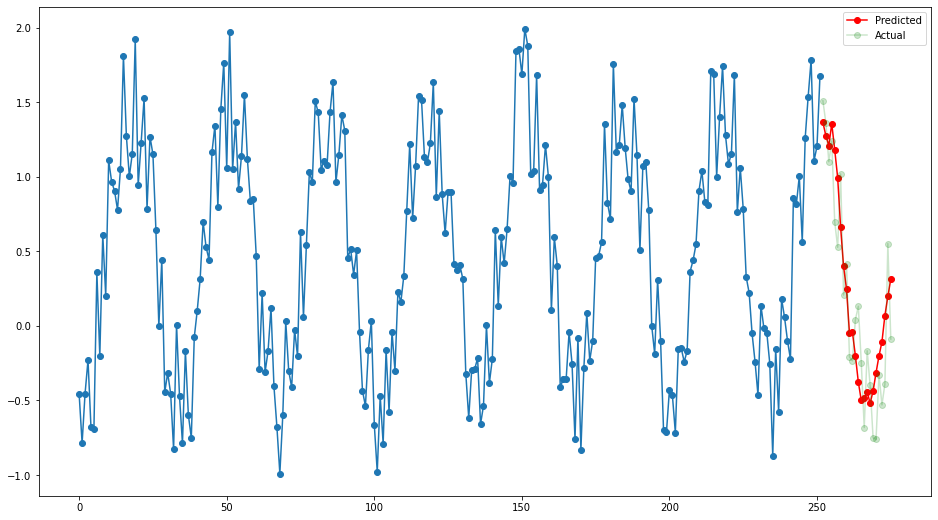

In [14]:
# 미래 예측 함수 테스트(sin 그래프)

# [ 조정 변수]

# 총 데이터
DATA = np.sin(2 * np.pi * 0.03 * np.arange(0, 300)) + np.random.random(300) # Sine 함수에 노이즈를 섞은 데이터로 학습 데이터 100개를 생성한다

# 과거 학습 단위 = 예측하게 되는 타겟 갯수
WINDOW_SIZE = 24

# past_learn: 과거 학습할 데이터 단위 
pred = pred_future(DATA,WINDOW_SIZE)

# bigstar
--- 

In [15]:
# 데이터 로딩
data = pd.read_csv('./data_m.csv')
target = pd.read_csv('./target.csv')

data_all = pd.concat([data,target[['CIVIL','IND']]], axis=1)

In [16]:
data_all['CIVIL']

0       605519
1       566323
2       477514
3       337797
4       184522
        ...   
295     398661
296     380235
297     616682
298    1093747
299    1921404
Name: CIVIL, Length: 300, dtype: int64

예측 개월 수: 24개월
--------------------------------
[ before reshape ]
x.shape: (276, 24)
y.shape: (276,)
[ after reshape ]
x.shape: (276, 24, 1)
y.shape: (276, 1)
x_train.shape: (252, 24, 1) y_train.shape: (252, 1)
x_test.shape : (24, 24, 1) y_test.shape : (24, 1)
Epoch 1/200
16/16 [==============================] - 1s 4ms/step - loss: 775323910144.0000
Epoch 2/200
16/16 [==============================] - 0s 4ms/step - loss: 445340647424.0000
Epoch 3/200
16/16 [==============================] - 0s 4ms/step - loss: 341241266176.0000
Epoch 4/200
16/16 [==============================] - 0s 4ms/step - loss: 288754302976.0000
Epoch 5/200
16/16 [==============================] - 0s 4ms/step - loss: 281291816960.0000
Epoch 6/200
16/16 [==============================] - 0s 4ms/step - loss: 289757265920.0000
Epoch 7/200
16/16 [==============================] - 0s 4ms/step - loss: 278736896000.0000
Epoch 8/200
16/16 [==============================] - 0s 4ms/step - loss: 248149032960.0000
Epoch 9/200

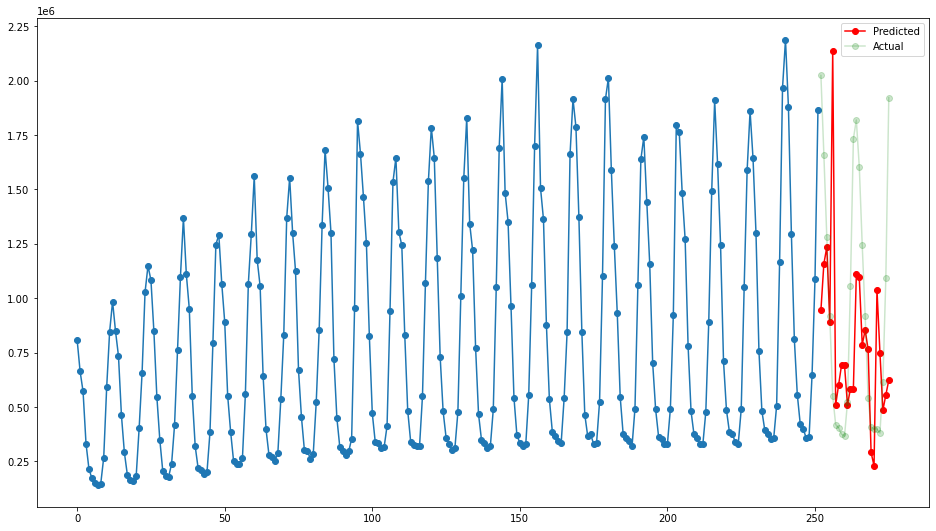

In [17]:
DATA = data_all['CIVIL']
WINDOW_SIZE = 24

y_hat = pred_future(DATA,WINDOW_SIZE)

In [18]:
y_hat 

array([[ 943650.8 ],
       [1158188.2 ],
       [1234560.  ],
       [ 891768.4 ],
       [2135934.  ],
       [ 509445.06],
       [ 601841.8 ],
       [ 693614.25],
       [ 690891.2 ],
       [ 509611.78],
       [ 583884.  ],
       [ 583339.4 ],
       [1108977.5 ],
       [1095245.8 ],
       [ 786939.4 ],
       [ 853431.7 ],
       [ 764754.94],
       [ 291151.94],
       [ 229684.8 ],
       [1036773.3 ],
       [ 750209.56],
       [ 485448.62],
       [ 555462.75],
       [ 623461.5 ]], dtype=float32)

In [19]:
data[-24:]

,YEAR,AT,LT,HT,CAP_TEMP_EF,DONGNAM_TEMP_EF,DAEGYUNG_TEMP_EF,CHOONG_TEMP_EF,HONAM_TEMP_EF,MEAN_TEMP_EF,...,civil_sum,argri_fishing,mining,manufact,ind_sum,QUARTER,Value,RV,GAS_PRICE_IND,OIL_PRICE
276,2019-01-01,0.090945,-0.489591,0.770012,0.72846,5.86011,6.72639,3.30583,1.84808,3.693774,...,23767256,1801466,131193,22944994,24877653,0,119760.8,0.77,80.13,103.66
277,2019-02-01,0.316498,-0.250702,1.169028,0.61754,5.82241,6.70350,3.26986,1.81516,3.645694,...,22417137,1783153,109407,20044293,21936853,0,119760.8,0.74,80.13,108.21
278,2019-03-01,0.952082,0.301757,1.869099,0.31742,5.75461,6.65660,3.16589,1.72985,3.524874,...,19512035,1489767,123191,21964020,23576978,0,119760.8,0.69,80.13,115.77
279,2019-04-01,1.485796,0.755276,2.519272,-0.01760,5.71760,6.62878,3.08767,1.67183,3.417656,...,19333441,1393877,129241,21584311,23107429,1,120997.2,0.66,80.13,120.99
280,2019-05-01,2.289929,1.556191,3.201629,-0.37652,5.65046,6.57870,3.00053,1.61505,3.293644,...,17728863,1188195,124602,21666558,22979355,1,120997.2,0.65,80.13,123.45
281,2019-06-01,2.622322,2.104358,3.370158,-0.49321,5.63192,6.56352,2.96558,1.59346,3.252254,...,18156183,1225693,121321,21116819,22463833,1,120997.2,0.70,80.13,115.01
282,2019-07-01,3.037832,2.679898,3.699188,-0.51455,5.59512,6.53587,2.93362,1.57147,3.224306,...,19679160,1218032,124549,21944682,23287263,2,123266.6,0.73,84.70,116.15
283,2019-08-01,3.225776,2.713196,3.843948,-0.47930,5.55658,6.51563,2.92089,1.55829,3.214418,...,23524552,1526133,117458,22390555,24034146,2,123266.6,0.73,84.70,115.29
284,2019-09-01,2.697327,2.025328,3.270082,-0.49788,5.60852,6.56712,2.96723,1.58791,3.246580,...,21150326,1479460,111080,20908651,22499191,2,123266.6,0.73,84.70,115.88
285,2019-10-01,2.002708,1.266371,2.748881,-0.24486,5.65838,6.60812,3.03990,1.62994,3.338296,...,18150214,1151917,126561,21194364,22472842,3,124910.1,0.73,84.70,116.43
